# DTLZ investigation

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
from summit.utils.models import GPyModel, ModelGroup
from summit.benchmarks import DTLZ2
from summit.strategies import TSEMO
import GPy
import pandas as pd
import numpy as np

## What are the model hyperparameters with the current scaling?

In [35]:
tsemo = TSEMO.load('data/new_tsemo_params_0.json')

In [192]:
tsemo.all_experiments

,computation_t,experiment_t,strategy,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1
0,0.000000,0.003122,LHS,0.983333,0.116667,0.116667,0.916667,0.416667,0.283333,0.039825,1.520868
1,0.000000,0.002728,LHS,0.350000,0.916667,0.650000,0.850000,0.850000,0.716667,1.268776,0.777507
2,0.000000,0.002726,LHS,0.483333,0.350000,0.416667,0.150000,0.783333,0.383333,0.903696,0.857575
3,0.000000,0.002717,LHS,0.016667,0.716667,0.216667,0.283333,0.150000,0.350000,1.318715,0.034532
4,0.000000,0.002712,LHS,0.283333,0.516667,0.083333,0.383333,0.216667,0.883333,1.276907,0.609054
...,...,...,...,...,...,...,...,...,...,...,...
124,111.363135,0.003047,TSEMO,0.001761,0.280111,0.371905,0.677321,0.019559,0.607584,1.338595,0.003702
125,111.558325,0.002916,TSEMO,0.524447,0.075475,0.518872,0.900647,0.028824,0.731627,1.098484,1.186265
126,111.378231,0.002873,TSEMO,0.056890,0.274022,0.326402,0.546352,0.708718,0.597907,1.131965,0.101425
127,113.206053,0.003059,TSEMO,0.445388,0.540284,0.266359,0.553372,0.944824,0.901513,1.085007,0.913173


In [193]:
model = tsemo.models['y_0']
lengthscales_y0 = model.hyperparameters[0]
mean = model.input_mean
std = model.input_std
lengthscales_y0 = lengthscales_y0*std+mean
print("y_0 lenghtscales:")
lengthscales_y0

y_0 lenghtscales:


array([12.27444488, 60.23541391, 40.95117799, 57.06712795, 61.05745584,
       53.89057719])

In [194]:
model = tsemo.models['y_1']
lengthscales_y1 = model.hyperparameters[0]
mean = model.input_mean
std = model.input_std
lengthscales_y1 = lengthscales_y1*std+mean
print("y_1 lenghtscales")
lengthscales_y1

y_1 lenghtscales


array([  9.67504564, 207.45117225,  41.68075642,  45.95922059,
        37.94677726,  32.97547317])

It's hard to compare this to the Matlab version because I realized the Matlab version scales the inputs between 0 and 1 and the outputs to zero mean and unit variance.

In [199]:
tsemo.models['y_0']._model.log_likelihood()

11.973012200124913

## Different Scaling

In [200]:
data = tsemo.all_experiments.copy()
input_columns = [v.name for v in tsemo.domain.input_variables]
output_columns = ['y_0', 'y_1']

In [201]:
# Scale decision variables between 0 and 1
inputs = data[input_columns]
input_min = inputs.min()
input_max = inputs.max()
scaled_inputs = (inputs-input_min)/(input_max-input_min)

# Scale objectives to 0 mean and unit variance
outputs = data[output_columns]
output_mean = outputs.mean()
output_std = outputs.std()
scaled_outputs = (outputs-output_mean)/output_std

# Join back
scaled_data = pd.concat([scaled_input, scaled_output], axis=1)
scaled_data

,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1
0,0.984074,0.109904,0.115399,0.932195,0.413793,0.284762,-1.823522,1.494427
1,0.349846,0.930989,0.652220,0.864390,0.862069,0.726118,0.777429,-0.146041
2,0.483368,0.349387,0.417361,0.152440,0.793103,0.386614,0.004773,0.030655
3,0.016043,0.725718,0.216053,0.288049,0.137931,0.352663,0.883119,-1.785659
4,0.283086,0.520447,0.081847,0.389757,0.206897,0.895870,0.794638,-0.517789
...,...,...,...,...,...,...,...,...
124,0.001115,0.277655,0.372306,0.688764,0.002992,0.615015,0.925194,-1.853695
125,0.524540,0.067626,0.520234,0.915902,0.012577,0.741355,0.417023,0.756016
126,0.056322,0.271406,0.326506,0.555558,0.715915,0.605159,0.487882,-1.638037
127,0.445369,0.544687,0.266070,0.562698,0.960163,0.914386,0.388500,0.153349


In [204]:
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
y0 =  scaled_outputs['y_0'].to_numpy()
y0 = np.atleast_2d(y0).T
model_y0 = GPy.models.GPRegression(
            scaled_inputs.to_numpy(),y0, kern, noise_var=1e-3
        )

In [205]:
_ = model_y0.optimize_restarts(num_restarts=100, 
                        verbose=False,
                        max_iters=10000,
                        parallel=True)

In [207]:
lengthscale = model_y0.kern.lengthscale.values
lengthscale = lengthscale*(input_max-input_min)+input_min
lengthscale

NAME  TYPE
x_0   DATA    11.790879
x_1   DATA    59.722268
x_2   DATA    40.502966
x_3   DATA    56.587710
x_4   DATA    60.570374
x_5   DATA    53.375054
dtype: float64

In [208]:
model_y0.log_likelihood()

12.47496020034471

In [212]:
model_y0.kern.variance.values*output_std['y_0']

TYPE
DATA    1.919842
dtype: float64

In [209]:
model_y0.Gaussian_noise.variance.values

array([1.16853061e-29])

These are quite different from the Matlab hyperparameters which are:

 Example Final hyperparameter values: 
 
 Hyperparameter | y0 | y1
 ---- | ---- | ----
 lambda1 | 5.1223 | 4.5762
 lambda2 | 16.9314 | 13.4619
 lambda3 | 19.4787 | 13.6769
 lambda4 | 13.6067 | 31.6228
 lambda5 | 20.3284 | 11.1775
 lambda6 | 13.5731 | 15.9444
  sigmaf | 0.5590  | 0.5159
  sigman |0.0012   |0.0012

## Try training on Matlab Data

In [134]:
# Read in data from one Matlab experiment
X = pd.read_csv('data/matlab/experiment_20/X.csv', names=[f"x_{i}" for i in range(6)])
y = pd.read_csv('data/matlab/experiment_20/Y.csv', names=['y_0', 'y_1'])

In [135]:
# Scale decision variables between 0 and 1
X_min = X.min()
X_max = X.max()
X_scaled = (X-X_min)/(X_max-X_min)

# Scale objectives to 0 mean and unit variance
y_mean = y.mean()
y_std = y.std()
y_scaled = (y-y_mean)/y_std

In [158]:
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
kern.lengthscale.set_prior(GPy.priors.Gamma(1, 0.1))
kern.variance.set_prior(GPy.priors.Gamma(1, 0.1))
y0_matlab =  y_scaled['y_0'].to_numpy()
y0_matlab = np.atleast_2d(y0_matlab).T
model_y0 = GPy.models.GPRegression(
            X_scaled,y0_matlab, kern, noise_var=1e-3
        )
model_y0.Gaussian_noise.variance.set_prior(GPy.priors.Gamma(0.5,0.1))

reconstraining parameters Exponential.lengthscale
reconstraining parameters Exponential.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


In [159]:
_ = model_y0.optimize_restarts(num_restarts=100, 
                        verbose=False,
                        max_iters=10000,
                        parallel=True)

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packa

In [160]:
lengthscale = model_y0.kern.lengthscale.values
lengthscale = lengthscale*(X_max-X_min)+X_min
lengthscale

x_0     2.670221
x_1     8.734688
x_2     9.973817
x_3     7.159520
x_4    10.290218
x_5     7.085365
dtype: float64

In [162]:
model_y0.Gaussian_noise.variance.values

array([0.0002171])

So it seems the problem is with the priors on the hyperparameters. By using a strong prior on the hyperameters (a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution#Scaling)), we end up with much better results.

## Retrain with priors

In [213]:
tsemo = TSEMO.load('data/new_tsemo_params_0.json')
data = tsemo.all_experiments.copy()
input_columns = [v.name for v in tsemo.domain.input_variables]
output_columns = ['y_0', 'y_1']

In [214]:
# Scale decision variables between 0 and 1
inputs = data[input_columns]
input_min = inputs.min()
input_max = inputs.max()
scaled_inputs = (inputs-input_min)/(input_max-input_min)

# Scale objectives to 0 mean and unit variance
outputs = data[output_columns]
output_mean = outputs.mean()
output_std = outputs.std()
scaled_outputs = (outputs-output_mean)/output_std

# Join back
scaled_data = pd.concat([scaled_input, scaled_output], axis=1)
scaled_data

,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1
0,0.984074,0.109904,0.115399,0.932195,0.413793,0.284762,-1.823522,1.494427
1,0.349846,0.930989,0.652220,0.864390,0.862069,0.726118,0.777429,-0.146041
2,0.483368,0.349387,0.417361,0.152440,0.793103,0.386614,0.004773,0.030655
3,0.016043,0.725718,0.216053,0.288049,0.137931,0.352663,0.883119,-1.785659
4,0.283086,0.520447,0.081847,0.389757,0.206897,0.895870,0.794638,-0.517789
...,...,...,...,...,...,...,...,...
124,0.001115,0.277655,0.372306,0.688764,0.002992,0.615015,0.925194,-1.853695
125,0.524540,0.067626,0.520234,0.915902,0.012577,0.741355,0.417023,0.756016
126,0.056322,0.271406,0.326506,0.555558,0.715915,0.605159,0.487882,-1.638037
127,0.445369,0.544687,0.266070,0.562698,0.960163,0.914386,0.388500,0.153349


In [221]:
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
y0 =  scaled_outputs['y_0'].to_numpy()
y0 = np.atleast_2d(y0).T
model_y0 = GPy.models.GPRegression(
            scaled_inputs.to_numpy(),y0, kern, noise_var=1e-3
        )
# model_y0.kern.lengthscale.set_prior(GPy.priors.Gamma(1, 0.1))
# model_y0.kern.variance.set_prior(GPy.priors.Gamma(1, 0.1))
model_y0.Gaussian_noise.variance.set_prior(GPy.priors.Gamma(0.5,0.1))

reconstraining parameters GP_regression.Gaussian_noise.variance


In [222]:
_ = model_y0.optimize_restarts(num_restarts=100, 
                        verbose=False,
                        max_iters=10000,
                        parallel=True)

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


In [217]:
lengthscale = model_y0.kern.lengthscale.values
lengthscale = lengthscale*(input_max-input_min)+input_min
lengthscale

NAME  TYPE
x_0   DATA    1.823878
x_1   DATA    9.266253
x_2   DATA    6.418694
x_3   DATA    8.931985
x_4   DATA    9.008365
x_5   DATA    8.582556
dtype: float64

In [218]:
model_y0.kern.variance*output_std['y_0']

TYPE
DATA    0.320016
dtype: float64

In [219]:
model_y0.Gaussian_noise.variance.values

array([0.00068906])

In [220]:
model_y0.log_likelihood()

9.80862267321848

## Sklearn

In [105]:
from sklearn.gaussian_process import GaussianProcessRegressor, 

In [103]:
# Read in data from one Matlab experiment
X = pd.read_csv('data/matlab/experiment_20/X.csv', names=[f"x_{i}" for i in range(6)])
y = pd.read_csv('data/matlab/experiment_20/Y.csv', names=['y_0', 'y_1'])

In [104]:
# Scale decision variables between 0 and 1
X_min = X.min()
X_max = X.max()
X_scaled = (X-X_min)/(X_max-X_min)

# Scale objectives to 0 mean and unit variance
y_mean = y.mean()
y_std = y.std()
y_scaled = (y-y_mean)/y_std

In [ ]:
kern = np.ones(6)*kernels.Matern(length_scale=[10 for i in range(6)], nu=1.5)
y0_m =  y_scaled['y_0'].to_numpy()
y0_matlab = np.atleast_2d(y0_matlab).T
gpr = GaussianProcessRegressor(kernel=kern,random_state=0).fit(X_scaled.to_numpy(), y0_matlab)
np.exp(kern.theta)

## Platypus NSGA-II Test

In [23]:
from scipy.optimize import OptimizeResult
import platypus as pp
from summit.benchmarks import DTLZ2
from summit.utils.dataset import DataSet
from summit.utils.multiobjective import pareto_efficient, HvI

In [15]:
class NSGAII():
    def __init__(self, experiment):
        self.experiment = experiment
        self.domain = self.experiment.domain

        # Set up platypus problem
        self.problem = pp.Problem(
            nvars=self.domain.num_variables(),
            nobjs=len(self.domain.output_variables),
            nconstrs=len(self.domain.constraints),
        )
        # Set maximization or minimization for each objective
        j=0
        for i, v in enumerate(self.domain.variables):
            if v.is_objective:
                direction = self.problem.MAXIMIZE if v.maximize else self.problem.MINIMIZE
                self.problem.directions[j] = direction
                j+=1
            elif v.variable_type == "continuous":
                self.problem.types[i] = pp.Real(v.lower_bound, v.upper_bound)
            elif v.variable_type == "discrete":
                # Select a subset of one of the available options
                raise NotImplementedError(
                    "The NSGAII optimizer does not work with discrete variables"
                )
                # self.problem.types[i] = pp.Subset(elements=v.levels, size=1)
            elif v.variable_type == "descriptors":
                raise NotImplementedError(
                    "The NSGAII optimizer does not work with descriptors variables"
                )
            else:
                raise TypeError(f"{v.variable_type} is not a valid variable type.")

        # Set up constraints
        self.problem.constraints[:] = [
            c.constraint_type + "0" for c in self.domain.constraints
        ]

    def optimize(self, **kwargs):
        input_columns = [v.name for v in self.domain.variables if not v.is_objective]
        output_columns = [v.name for v in self.domain.variables if v.is_objective]

        def problem_wrapper(X):
            X = DataSet(np.atleast_2d(X), columns=input_columns)
            X[("strategy", "METADATA")] = "NSGAII"
            result = self.experiment.run_experiments(X)
            if self.domain.constraints:
                constraint_res = [
                    X.eval(c.lhs, resolvers=[X]) for c in self.domain.constraints
                ]
                constraint_res = [c.tolist()[0] for c in constraint_res]

                return result[output_columns].to_numpy()[0,:], constraint_res
            else:
                return result[output_columns].to_numpy()[0,:]

        # Run optimization
        self.problem.function = problem_wrapper
        algorithm = pp.NSGAII(self.problem, population_size=1000)
        iterations = kwargs.get("iterations", 1000)
        algorithm.run(iterations)

        x = [
            [s.variables[i] for i in range(self.domain.num_variables())]
            for s in algorithm.result
            if s.feasible
        ]
        x = DataSet(x, columns=input_columns)
        y = [
            [s.objectives[i] for i in range(len(self.domain.output_variables))]
            for s in algorithm.result
            if s.feasible
        ]
        y = DataSet(y, columns=output_columns)
        return OptimizeResult(x=x, fun=y, success=True)

In [16]:
dtlz2 = DTLZ2()
nsgaii = NSGAII(dtlz2)

In [17]:
r = nsgaii.optimize()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1243d7278>)

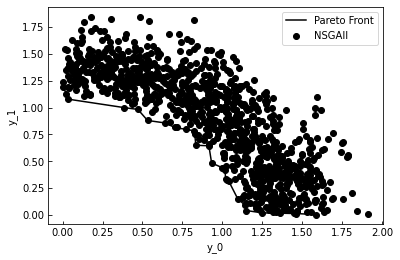

In [18]:
dtlz2.pareto_plot()

This is really not good. The pareto front is between (1,0) and (0,1) and it clearly does not find it. Furthermore, as shown below, none of the optimal points (x*=0.5) are found.

In [21]:
data = dtlz2.data
data[(data['x_0']<0.51) & (data['x_0']>0.49)]

,computation_t,experiment_t,strategy,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1
0,0,0.00817013,NSGAII,0.502827,0.531149,0.132505,0.750924,0.153492,0.317094,0.952111,0.960606
11,0.00430202,0.00404096,NSGAII,0.507255,0.785163,0.902755,0.848710,0.307409,0.587246,0.985476,1.008198
40,0.00349808,0.00400591,NSGAII,0.498186,0.712510,0.844802,0.532695,0.850232,0.872515,1.011592,1.005843
80,0.0035007,0.00388527,NSGAII,0.490512,0.780019,0.847606,0.050713,0.205446,0.675281,1.089685,1.057679
132,0.00354791,0.00395608,NSGAII,0.494854,0.679649,0.401917,0.237922,0.160769,0.378278,0.884208,0.870028
147,0.00366306,0.00558114,NSGAII,0.500844,0.955894,0.939264,0.053531,0.678112,0.341210,1.170168,1.173273
260,0.00384212,0.00426078,NSGAII,0.509292,0.019488,0.537181,0.070103,0.271896,0.214008,1.080536,1.112547
291,0.00431609,0.00756598,NSGAII,0.504796,0.271182,0.874596,0.145555,0.286757,0.070730,1.086364,1.102856
394,0.00356388,0.00449896,NSGAII,0.490644,0.799881,0.262535,0.494841,0.157639,0.380277,0.916786,0.890227
398,0.00366402,0.00387931,NSGAII,0.499750,0.812385,0.894907,0.863084,0.139628,0.306220,1.098416,1.097553


In [27]:
y_front, _ = pareto_efficient(data[['y_0', 'y_1']].to_numpy(), maximize=False)
HvI.hypervolume(y_front, ref=[11,11])

119.96807465297428

## Pymoo NSGA-II

In [24]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter


In [9]:
problem = get_problem("dtlz2", n_var=6, n_obj=2)

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=False)

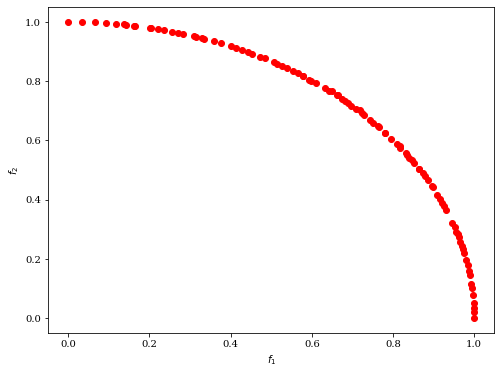

In [10]:
plot = Scatter()
# plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
plot.show()

## Pymoo NSGA-II TSEMO

In [37]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

from summit.strategies.tsemo import TSEMOInternalWrapper

In [38]:
tsemo = TSEMO.load('data/new_tsemo_params_0.json')
data = tsemo.all_experiments.copy()
input_columns = [v.name for v in tsemo.domain.input_variables]
output_columns = ['y_0', 'y_1']

In [39]:
# Scale decision variables between 0 and 1
inputs = data[input_columns]
input_min = inputs.min()
input_max = inputs.max()
scaled_inputs = (inputs-input_min)/(input_max-input_min)

# Scale objectives to 0 mean and unit variance
outputs = data[output_columns]
output_mean = outputs.mean()
output_std = outputs.std()
scaled_outputs = (outputs-output_mean)/output_std

# Join back
scaled_data = pd.concat([scaled_inputs, scaled_outputs], axis=1)
scaled_data

,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1
0,0.984074,0.109904,0.115399,0.932195,0.413793,0.284762,-1.823522,1.494427
1,0.349846,0.930989,0.652220,0.864390,0.862069,0.726118,0.777429,-0.146041
2,0.483368,0.349387,0.417361,0.152440,0.793103,0.386614,0.004773,0.030655
3,0.016043,0.725718,0.216053,0.288049,0.137931,0.352663,0.883119,-1.785659
4,0.283086,0.520447,0.081847,0.389757,0.206897,0.895870,0.794638,-0.517789
...,...,...,...,...,...,...,...,...
124,0.001115,0.277655,0.372306,0.688764,0.002992,0.615015,0.925194,-1.853695
125,0.524540,0.067626,0.520234,0.915902,0.012577,0.741355,0.417023,0.756016
126,0.056322,0.271406,0.326506,0.555558,0.715915,0.605159,0.487882,-1.638037
127,0.445369,0.544687,0.266070,0.562698,0.960163,0.914386,0.388500,0.153349


In [27]:
models = ModelGroup({'y_0':GPyModel(input_dim=6), 'y_1':GPyModel(input_dim=6)})
models.fit(scaled_inputs, scaled_outputs, spectral_sample=True)

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:565: RuntimeWarning:invalid value encountered in multiply
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:568: RuntimeWarning:invalid value encountered in subtract
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/pa

In [28]:
problem = TSEMOInternalWrapper(models, tsemo.domain, )
algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=False)

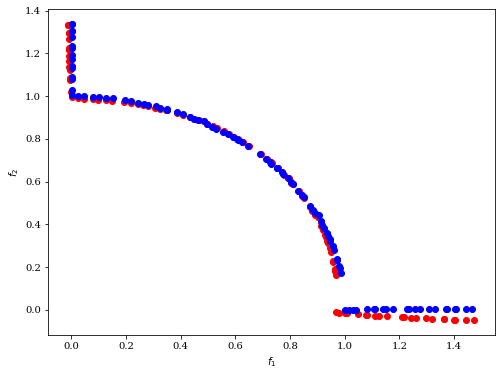

In [41]:
plot = Scatter()

y = res.F*output_std.to_numpy() + output_mean.to_numpy()
plot.add(y, color="red")
problem = get_problem("dtlz2", n_var=6, n_obj=2)
X_unscaled = res.X*(input_max.to_numpy()-input_min.to_numpy())+input_min.to_numpy()
y_real = problem.evaluate(X_unscaled)
plot.add(y_real, color="blue")
plot.show()

That looks promising!